In [2]:
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from os import listdir, getcwd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pickle
from lib import unet
from lib import generator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
DATA_DIR = join(getcwd(), 'data')
TRAIN_DIR = join(DATA_DIR, 'train')
MASK_DIR = join(DATA_DIR, 'train_masks')
TRAIN_IMAGE_LIST = sorted(listdir(TRAIN_DIR))
MASK_IMAGE_LIST = sorted(listdir(MASK_DIR))
IMG_WIDTH = 320

In [4]:
train_images, test_images, train_masks, test_masks = train_test_split(TRAIN_IMAGE_LIST, 
                                                                      MASK_IMAGE_LIST, 
                                                                      test_size=0.10000)
train_images, validation_images, train_masks, validation_masks = train_test_split(train_images,
                                                                                  train_masks,
                                                                                  test_size=0.11111)

### Augmentations - 320px

In [15]:
train_generator = generator.image_generator(TRAIN_DIR, 
                                            MASK_DIR, 
                                            train_images, 
                                            train_masks, 
                                            batch_size = 2, 
                                            img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                            num_colors = 8)

validation_generator = generator.image_generator(TRAIN_DIR, 
                                                 MASK_DIR, 
                                                 validation_images, 
                                                 validation_masks, 
                                                 batch_size = 2, 
                                                 img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                                 num_colors = 8)

test_generator = generator.image_generator(TRAIN_DIR, 
                                           MASK_DIR, 
                                           test_images, 
                                           test_masks, 
                                           batch_size = 2, 
                                           img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                           num_colors = 8)

In [16]:
import keras.backend as K
K.clear_session()

In [17]:
model = unet.get_unet_model([IMG_WIDTH, IMG_WIDTH, 3])

model.compile(optimizer=Adam(1e-4), 
              loss='binary_crossentropy',
              metrics=[unet.dice_coef])

In [18]:
checkpoint = ModelCheckpoint('best-fit-model-aug-320.hdf5',
                             monitor='val_dice_coef',
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

In [ ]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch = 2035,
                           epochs = 10,
                           validation_data = validation_generator,
                           validation_steps = 252,
                           callbacks=[checkpoint])
model.save('hist-aug-320.h5')

Epoch 1/10
  27/2035 [..............................] - ETA: 6713s - loss: 0.6518 - dice_coef: 0.0054

In [ ]:
pickle.dump(hist.history, open('hist-aug-320.pkl', 'wb'))

### Augmentation - 640px

In [4]:
IMG_WIDTH = 640

In [5]:
train_generator = generator.image_generator(TRAIN_DIR, 
                                            MASK_DIR, 
                                            train_images, 
                                            train_masks, 
                                            batch_size = 2, 
                                            img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                            num_colors = 8)

validation_generator = generator.image_generator(TRAIN_DIR, 
                                                 MASK_DIR, 
                                                 validation_images, 
                                                 validation_masks, 
                                                 batch_size = 2, 
                                                 img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                                 num_colors = 8)

test_generator = generator.image_generator(TRAIN_DIR, 
                                           MASK_DIR, 
                                           test_images, 
                                           test_masks, 
                                           batch_size = 2, 
                                           img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                           num_colors = 8)

In [6]:
import keras.backend as K
K.clear_session()

In [7]:
model = unet.get_unet_model([IMG_WIDTH, IMG_WIDTH, 3])

model.compile(optimizer=Adam(1e-4), 
              loss='binary_crossentropy',
              metrics=[unet.dice_coef])

In [8]:
checkpoint = ModelCheckpoint('best-fit-model-aug-640.hdf5',
                             monitor='val_dice_coef',
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

In [ ]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch = 2035,
                           epochs = 10,
                           validation_data = validation_generator,
                           validation_steps = 252,
                           callbacks=[checkpoint])
model.save('hist-aug-640.h5')
pickle.dump(hist.history, open('hist-aug-640.pkl', 'wb'))

Epoch 1/10
2035/2035 [==============================] - 6785s - loss: 0.1040 - dice_coef: 0.7966 - val_loss: 0.0223 - val_dice_coef: 0.9747
Epoch 2/10
2035/2035 [==============================] - 6724s - loss: 0.1073 - dice_coef: 0.8539 - val_loss: 0.0393 - val_dice_coef: 0.9573
Epoch 3/10
2035/2035 [==============================] - 6709s - loss: 0.0429 - dice_coef: 0.9523 - val_loss: 0.0299 - val_dice_coef: 0.9646
Epoch 4/10
2035/2035 [==============================] - 6709s - loss: 0.0251 - dice_coef: 0.9722 - val_loss: 0.0168 - val_dice_coef: 0.9818
Epoch 5/10
2035/2035 [==============================] - 6750s - loss: 0.0217 - dice_coef: 0.9749 - val_loss: 0.1360 - val_dice_coef: 0.8182
Epoch 6/10
2035/2035 [==============================] - 6752s - loss: 0.0429 - dice_coef: 0.9421 - val_loss: 0.0196 - val_dice_coef: 0.9788
Epoch 7/10
2035/2035 [==============================] - 6725s - loss: 0.0127 - dice_coef: 0.9852 - val_loss: 0.0146 - val_dice_coef: 0.9832
Epoch 8/10
2035/2035

### No Augmentation - 320px

In [ ]:
IMG_WIDTH = 320

In [ ]:
train_generator = generator.image_generator_no_aug(TRAIN_DIR, 
                                            MASK_DIR, 
                                            train_images, 
                                            train_masks, 
                                            batch_size = 2, 
                                            img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                            num_colors = 8)

validation_generator = generator.image_generator_no_aug(TRAIN_DIR, 
                                                 MASK_DIR, 
                                                 validation_images, 
                                                 validation_masks, 
                                                 batch_size = 2, 
                                                 img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                                 num_colors = 8)

test_generator = generator.image_generator_no_aug(TRAIN_DIR, 
                                           MASK_DIR, 
                                           test_images, 
                                           test_masks, 
                                           batch_size = 2, 
                                           img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                           num_colors = 8)

In [ ]:
import keras.backend as K
K.clear_session()

In [ ]:
model = unet.get_unet_model([IMG_WIDTH, IMG_WIDTH, 3])

model.compile(optimizer=Adam(1e-4), 
              loss='binary_crossentropy',
              metrics=[unet.dice_coef])

In [ ]:
checkpoint = ModelCheckpoint('best-fit-model-no-aug-320.hdf5',
                             monitor='val_dice_coef',
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

In [ ]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch = 2035,
                           epochs = 10,
                           validation_data = validation_generator,
                           validation_steps = 252,
                           callbacks=[checkpoint])
model.save('hist-no-aug-320.h5')
pickle.dump(hist.history, open('hist-no-aug-320.pkl', 'wb'))

### No Augmentation - 640px

In [4]:
IMG_WIDTH = 640

In [5]:
train_generator = generator.image_generator_no_aug(TRAIN_DIR, 
                                            MASK_DIR, 
                                            train_images, 
                                            train_masks, 
                                            batch_size = 2, 
                                            img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                            num_colors = 8)

validation_generator = generator.image_generator_no_aug(TRAIN_DIR, 
                                                 MASK_DIR, 
                                                 validation_images, 
                                                 validation_masks, 
                                                 batch_size = 2, 
                                                 img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                                 num_colors = 8)

test_generator = generator.image_generator_no_aug(TRAIN_DIR, 
                                           MASK_DIR, 
                                           test_images, 
                                           test_masks, 
                                           batch_size = 2, 
                                           img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                           num_colors = 8)

In [6]:
import keras.backend as K
K.clear_session()

In [7]:
model = unet.get_unet_model([IMG_WIDTH, IMG_WIDTH, 3])

model.compile(optimizer=Adam(1e-4), 
              loss='binary_crossentropy',
              metrics=[unet.dice_coef])

In [8]:
checkpoint = ModelCheckpoint('best-fit-model-no-aug-640.hdf5',
                             monitor='val_dice_coef',
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

In [9]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch = 2035,
                           epochs = 10,
                           validation_data = validation_generator,
                           validation_steps = 252,
                           callbacks=[checkpoint])
model.save('hist-no-aug-640.h5')
pickle.dump(hist.history, open('hist-no-aug-640.pkl', 'wb'))

Epoch 1/10
2035/2035 [==============================] - 6835s - loss: 0.1207 - dice_coef: 0.7713 - val_loss: 0.0835 - val_dice_coef: 0.9272
Epoch 2/10
2035/2035 [==============================] - 6714s - loss: 0.0413 - dice_coef: 0.9498 - val_loss: 0.1586 - val_dice_coef: 0.8044
Epoch 3/10
2035/2035 [==============================] - 6678s - loss: 0.0307 - dice_coef: 0.9658 - val_loss: 0.0153 - val_dice_coef: 0.9812
Epoch 4/10
2035/2035 [==============================] - 6701s - loss: 0.0395 - dice_coef: 0.9483 - val_loss: 0.0181 - val_dice_coef: 0.9773
Epoch 5/10
2035/2035 [==============================] - 6692s - loss: 0.0240 - dice_coef: 0.9745 - val_loss: 0.0170 - val_dice_coef: 0.9795
Epoch 6/10
2035/2035 [==============================] - 6672s - loss: 0.0157 - dice_coef: 0.9822 - val_loss: 0.0110 - val_dice_coef: 0.9868
Epoch 7/10
2035/2035 [==============================] - 6670s - loss: 0.0252 - dice_coef: 0.9761 - val_loss: 0.0175 - val_dice_coef: 0.9837
Epoch 8/10
2035/2035

In [14]:
!tar -zcvf models.tar.gz models

models/
models/hist-aug-640.pkl
models/hist-aug-320.pkl
models/best-fit-model-aug-320.hdf5
models/best-fit-model-aug-640.hdf5
models/hist-no-aug-640.pkl
models/hist-no-aug-320.h5
models/hist-aug-320.h5
models/hist-no-aug-640.h5
models/best-fit-model-no-aug-640.hdf5
models/best-fit-model-no-aug-320.hdf5
models/hist-no-aug-320.pkl
models/hist-aug-640.h5


In [5]:
IMG_WIDTH = 320
test_320_gen = generator.image_generator_no_aug(TRAIN_DIR, 
                                           MASK_DIR, 
                                           test_images, 
                                           test_masks, 
                                           batch_size = 5, 
                                           img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                           num_colors = 8)
IMG_WIDTH = 640
test_640_gen = generator.image_generator_no_aug(TRAIN_DIR, 
                                           MASK_DIR, 
                                           test_images, 
                                           test_masks, 
                                           batch_size = 2, 
                                           img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                           num_colors = 8)

In [8]:
from keras.models import load_model
model_no_aug_320 = load_model('./models/hist-no-aug-320.h5', custom_objects={'dice_coef': unet.dice_coef})
model_no_aug_640 = load_model('./models/hist-no-aug-640.h5', custom_objects={'dice_coef': unet.dice_coef})
model_aug_320 = load_model('./models/hist-aug-320.h5', custom_objects={'dice_coef': unet.dice_coef})
model_aug_640 = load_model('./models/hist-aug-640.h5', custom_objects={'dice_coef': unet.dice_coef})

In [9]:
eval_no_aug_320 = model_no_aug_320.evaluate_generator(test_320_gen, steps=102)
eval_aug_320 = model_aug_320.evaluate_generator(test_320_gen, steps=102)
eval_no_aug_640 = model_no_aug_640.evaluate_generator(test_640_gen, steps=252)
eval_aug_640 = model_aug_640.evaluate_generator(test_640_gen, steps=252)

In [14]:
eval_aug_320

[0.049689469822481569, 0.94595987539665372]

In [16]:
eval_no_aug_320

[0.016886834283450655, 0.97699464886796239]

In [15]:
eval_aug_640

[0.0081400896093645498, 0.98960665223144351]

In [17]:
eval_no_aug_640

[0.010473702982481983, 0.9877012837973852]

In [21]:
hist_aug_320 = pickle.load(open('./models/hist-aug-320.pkl', 'rb'))
hist_aug_640 = pickle.load(open('./models/hist-aug-640.pkl', 'rb'))
hist_no_aug_320 = pickle.load(open('./models/hist-no-aug-320.pkl', 'rb'))
hist_no_aug_640 = pickle.load(open('./models/hist-no-aug-640.pkl', 'rb'))

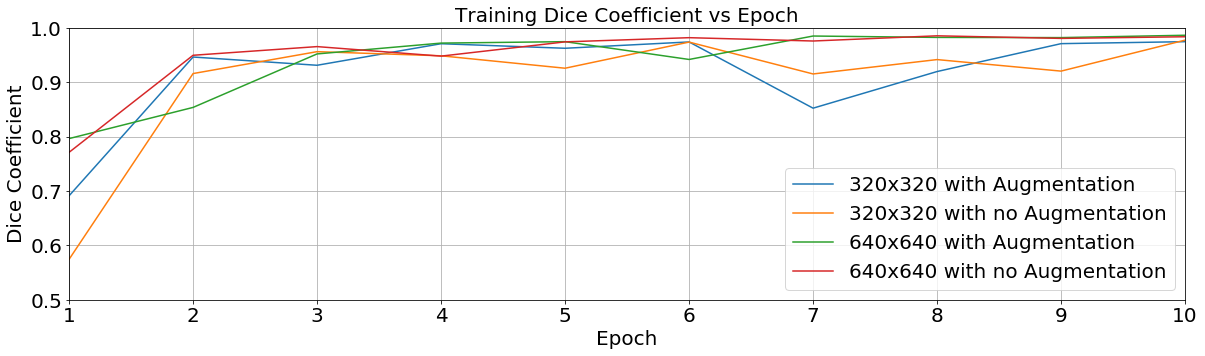

In [64]:
plt.figure(figsize = (20, 5))
x_range = np.arange(10) + 1
plt.plot(x_range, hist_aug_320.get('dice_coef'), label='320x320 with Augmentation')
plt.plot(x_range, hist_no_aug_320.get('dice_coef'), label='320x320 with no Augmentation')
plt.plot(x_range, hist_aug_640.get('dice_coef'), label='640x640 with Augmentation')
plt.plot(x_range, hist_no_aug_640.get('dice_coef'), label='640x640 with no Augmentation')
plt.title('Training Dice Coefficient vs Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Dice Coefficient', fontsize=20)
plt.ylim(0.5, 1.0)
plt.xlim(1, 10)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(prop={'size': 20})
plt.savefig('training-dice.png', bbox_inches='tight')
plt.show()

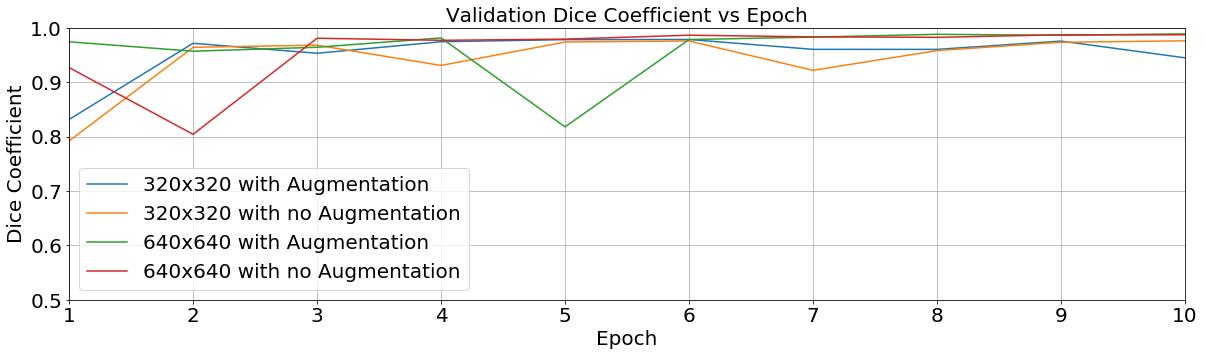

In [65]:
plt.figure(figsize = (20, 5))
x_range = np.arange(10) + 1
plt.plot(x_range, hist_aug_320.get('val_dice_coef'), label='320x320 with Augmentation')
plt.plot(x_range, hist_no_aug_320.get('val_dice_coef'), label='320x320 with no Augmentation')
plt.plot(x_range, hist_aug_640.get('val_dice_coef'), label='640x640 with Augmentation')
plt.plot(x_range, hist_no_aug_640.get('val_dice_coef'), label='640x640 with no Augmentation')
plt.title('Validation Dice Coefficient vs Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Dice Coefficient', fontsize=20)
plt.ylim(0.5, 1.0)
plt.xlim(1, 10)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(prop={'size': 20})
plt.savefig('validation-dice.png', bbox_inches='tight')
plt.show()

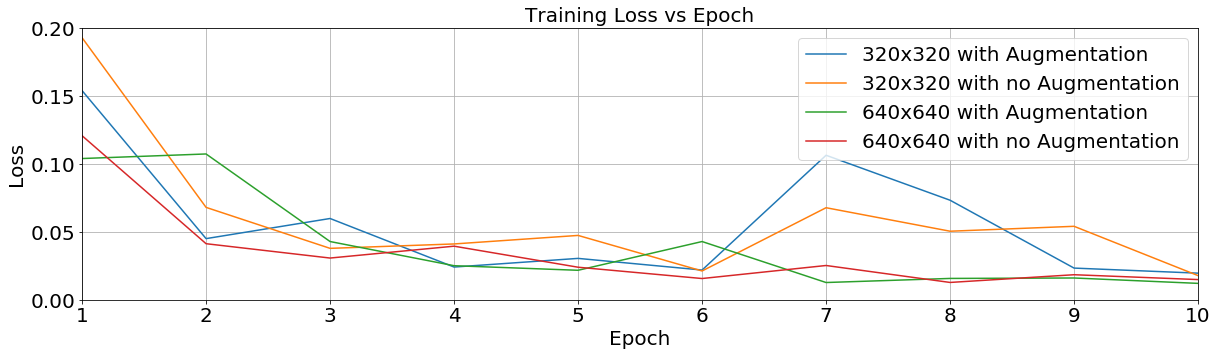

In [66]:
plt.figure(figsize = (20, 5))
x_range = np.arange(10) + 1
plt.plot(x_range, hist_aug_320.get('loss'), label='320x320 with Augmentation')
plt.plot(x_range, hist_no_aug_320.get('loss'), label='320x320 with no Augmentation')
plt.plot(x_range, hist_aug_640.get('loss'), label='640x640 with Augmentation')
plt.plot(x_range, hist_no_aug_640.get('loss'), label='640x640 with no Augmentation')
plt.title('Training Loss vs Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.ylim(0, 0.20)
plt.xlim(1, 10)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(prop={'size': 20})
plt.savefig('training-loss.png', bbox_inches='tight')
plt.show()

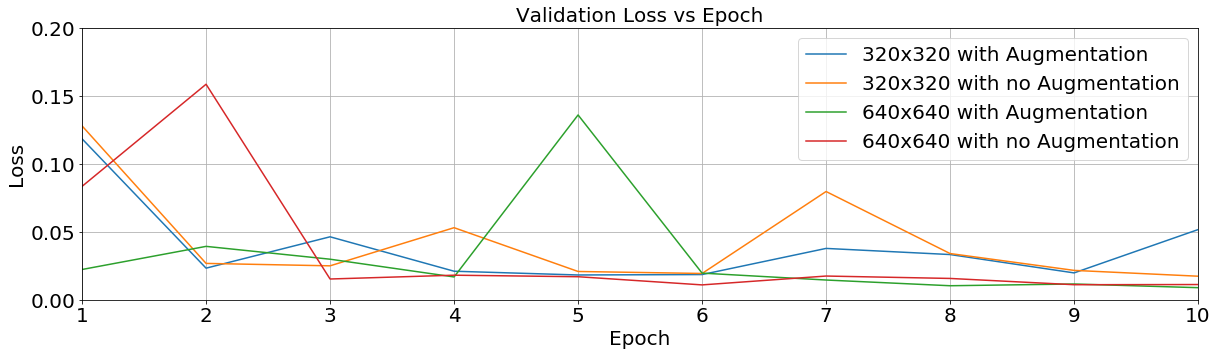

In [67]:
plt.figure(figsize = (20, 5))
x_range = np.arange(10) + 1
plt.plot(x_range, hist_aug_320.get('val_loss'), label='320x320 with Augmentation')
plt.plot(x_range, hist_no_aug_320.get('val_loss'), label='320x320 with no Augmentation')
plt.plot(x_range, hist_aug_640.get('val_loss'), label='640x640 with Augmentation')
plt.plot(x_range, hist_no_aug_640.get('val_loss'), label='640x640 with no Augmentation')
plt.title('Validation Loss vs Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.ylim(0, 0.20)
plt.xlim(1, 10)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(prop={'size': 20})
plt.savefig('validation-loss.png', bbox_inches='tight')
plt.show()

In [68]:
imgs, msks = next(test_640_gen)

In [70]:
pred = model_aug_640.predict_on_batch(imgs)

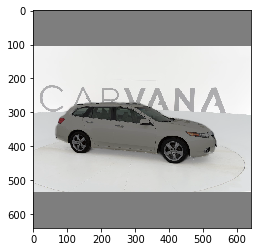

In [79]:
plt.imshow(imgs[0])
plt.imshow(pred[0][:,:,0], cmap='gray_r', alpha=0.5)
plt.show()

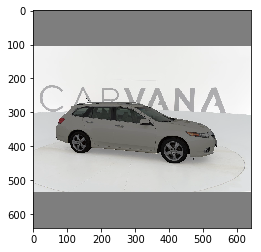

In [81]:
plt.imshow(imgs[0])
plt.imshow(msks[0][:,:,0], cmap='gray_r', alpha=0.5)
plt.show()

In [ ]:
!conda install -c conda-forge opencv

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /home/aa3250/miniconda3:

The following NEW packages will be INSTALLED:

    backports.functools_lru_cache: 1.4-py36_1                   conda-forge
    blas:                          1.1-openblas                 conda-forge
    bzip2:                         1.0.6-1                      conda-forge
    cairo:                         1.14.6-5                     conda-forge
    ffmpeg:                        3.2.4-3                      conda-forge
    gettext:                       0.19.7-1                     conda-forge
    giflib:                        5.1.4-0                      conda-forge
    harfbuzz:                      1.3.4-2                      conda-forge
    jasper:                        1.900.1-4                    conda-forge
    libgfortran:                   3.0.0-1                                 
    libiconv:                      1.15-0      

In [ ]:
!y